# モジュールをインポート

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib; matplotlib.rc('font', family='TakaoPGothic')
import pickle
import pandas as pd
import seaborn as sns
sns.set_context("talk")

# 学習歴史を読み込み

In [2]:
results_path = "keras_2020_01_23_11_56"
results_path = "./results/" + results_path 
with open(results_path + "/train_hist", "rb") as file:
    history = pickle.load(file)

# 学習正解率を描画

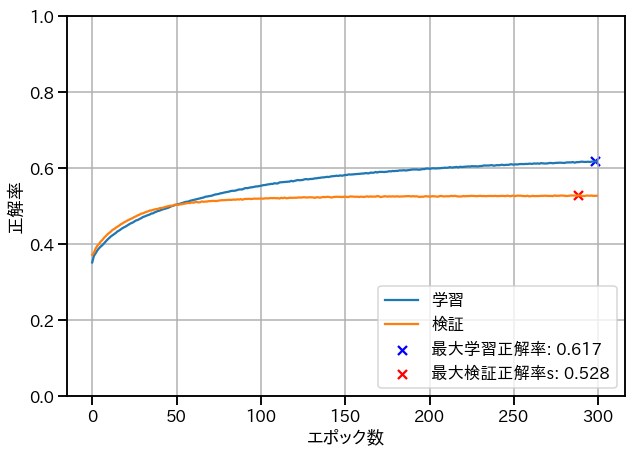

In [4]:
plt.figure(figsize=(10, 7))
plt.plot(history['acc'], color="C0", label="学習")
plt.plot(history['val_acc'], color="C1", label="検証")
max_val_index = np.argmax(history["acc"])
max_val = history["acc"][max_val_index]
# plt.annotate("Max Acc", xy=(max_val_index, history["val_acc"][max_val_index]), xycoords="data", label=("Max Val Acc: " + str(max_val.round(2))))
plt.scatter(max_val_index, history["acc"][max_val_index], marker="x", color="blue", label=("最大学習正解率: " + str(max_val.round(3))))
max_val_index = np.argmax(history["val_acc"])
max_val = history["val_acc"][max_val_index]
# plt.annotate("Max Acc", xy=(max_val_index, history["val_acc"][max_val_index]), xycoords="data", label=("Max Val Acc: " + str(max_val.round(2))))
plt.scatter(max_val_index, history["val_acc"][max_val_index], marker="x", color="red", label=("最大検証正解率s: " + str(max_val.round(3))))
# plt.title("Results")
plt.ylabel('正解率')
plt.xlabel('エポック数')
plt.legend(loc="lower right")
plt.grid()
plt.ylim(0, 1)
plt.show()

# 学習損失を描画

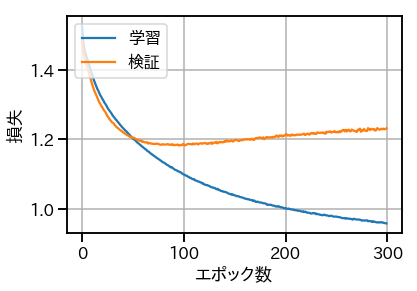

In [7]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel('損失')
plt.xlabel('エポック数')
plt.legend(['学習', '検証'], loc='upper left')
plt.grid()
plt.show()

# 検証データセットを読み込み

In [8]:
random_state = 33
dataset_dir = "./dataset/preprocessed_dataset/"
result_dir = "./results/"
with open(dataset_dir+"1_108_1x4_dataset_3D_win_10_normalize_False_overlap_True.pkl", "rb") as fp:
    dataset = pickle.load(fp)
with open(dataset_dir+"1_108_1x4_label_3D_win_10_normalize_False_overlap_True.pkl", "rb") as fp:
    labels = pickle.load(fp)
height = dataset.shape[2]
width = dataset.shape[3]
window_size = dataset.shape[1]

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(dataset, labels, test_size=0.25, random_state=random_state, shuffle=True)
print("Train dataset shape:", X_train.shape)
print("Train label shape:", y_train.shape)
print("Test dataset shape:", X_valid.shape)
print("Test label shape:", y_valid.shape)

Train dataset shape: (463810, 10, 1, 4)
Train label shape: (463810,)
Test dataset shape: (154604, 10, 1, 4)
Test label shape: (154604,)


In [9]:
# dataset_dir = "./dataset/preprocessed_dataset/"

# with open(dataset_dir+"1_81_shuffle_dataset_3D_win_10.pkl", "rb") as fp:
#     X_train = pickle.load(fp)
# with open(dataset_dir+"1_81_shuffle_labels_3D_win_10.pkl", "rb") as fp:
#     y_train = pickle.load(fp)
# X_train = X_train.reshape(-1, 10, 10, 11, 1)
# print("Dataset shape:", X_train.shape)
# print("Labels shape:", y_train.shape)

# print(X_train[0, 2].reshape(10, 11))

# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse=False)

# y_train = y_train.reshape(-1, 1)
# y_train = ohe.fit_transform(y_train)

# # # Validation data 4-channel 82-108 

# dataset_dir = "./dataset/preprocessed_dataset/"
# result_dir = "./results/"

# with open(dataset_dir+"82_108_shuffle_dataset_3D_win_10.pkl", "rb") as fp:
#     X_valid = pickle.load(fp)
# with open(dataset_dir+"82_108_shuffle_labels_3D_win_10.pkl", "rb") as fp:
#     y_valid = pickle.load(fp)
# X_valid = X_valid.reshape(-1, 10, 10, 11, 1)
# print("Dataset shape:", X_valid.shape)
# print("Labels shape:", y_valid.shape)

# print(X_valid[0, 2].reshape(10, 11))

# y_valid = y_valid.reshape(-1, 1)
# y_valid = ohe.transform(y_valid)

# ラベルエンコーディング

In [10]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

y_train = y_train.reshape(-1, 1)
y_train = ohe.fit_transform(y_train)
y_valid = y_valid.reshape(-1, 1)
y_valid = ohe.transform(y_valid)

# 正規化

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = X_train.reshape(-1, height*width)
X_valid = X_valid.reshape(-1, height*width)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_train = X_train.reshape(-1, window_size, height, width, 1)
X_valid = X_valid.reshape(-1, window_size, height, width, 1)

# モデルを定義

In [12]:
# dropout_prob = 0.5
# n_labels = y_train.shape[1]
# batch_size = 300
# learning_rate = 1e-4

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Conv2D, Conv3D
# from tensorflow.keras.layers import Reshape, Flatten, Softmax
# from tensorflow.keras.optimizers import Adam

# def model(input_shape):
#     """
#     Function creating the model's graph in Keras.
    
#     Argument:
#     input_shape -- shape of the model's input data (using Keras conventions)

#     Returns:
#     model -- Keras model instance
#     """
#     X_input = Input(shape = input_shape)
    
#     conv_1 = Conv3D(filters=32, kernel_size=(1, 3, 3), padding="same", strides=(1, 1, 1), activation="elu")(X_input)
#     conv_2 = Conv3D(filters=64, kernel_size=(1, 3, 3), padding="same", strides=(1, 1, 1), activation="elu")(conv_1)
#     conv_3 = Conv3D(filters=128, kernel_size=(1, 3, 3), padding="same", strides=(1, 1, 1), activation="elu")(conv_2)
#     shape = conv_3.get_shape().as_list()
    
#     pool_2_flat = Reshape([shape[1], shape[2]*shape[3]*shape[4]])(conv_3)
#     fc = Dense(1024, activation="elu")(pool_2_flat)
#     fc_drop = Dropout(dropout_prob)(fc)
    
#     lstm_in = Reshape([10, 1024])(fc_drop)
#     lstm_1 = LSTM(units=1024, return_sequences=True, unit_forget_bias=True, dropout=dropout_prob)(lstm_in)
#     rnn_output = LSTM(units=1024, return_sequences=False, unit_forget_bias=True)(lstm_1)
    
#     shape_rnn_out = rnn_output.get_shape().as_list()
#     fc_out = Dense(shape_rnn_out[1], activation="elu")(rnn_output)
#     fc_drop = Dropout(dropout_prob)(fc_out)
#     y_ = Dense(n_labels)(fc_drop)
#     y_posi = Softmax()(y_)
    
#     model = Model(inputs = X_input, outputs = y_posi)
#     return model
# model = model(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4]))
# model.load_weights(results_path + "/model/cp.ckpt")

In [13]:
from tensorflow.keras.models import load_model

model = load_model(results_path + "/model/model.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# モデルの確認

In [14]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1, 4, 1)]     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 10, 1, 4, 128)     384       
_________________________________________________________________
reshape (Reshape)            (None, 10, 512)           0         
_________________________________________________________________
dense (Dense)                (None, 10, 256)           131328    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 512)           787968

# テストデータを分類

In [15]:
n_labels = y_valid.shape[1]
batch_size = 300
y_pred = model.predict(X_valid, batch_size=batch_size, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

154604/154604 [==============================] - 13s 81us/sample


# 精度と正解率の曲線

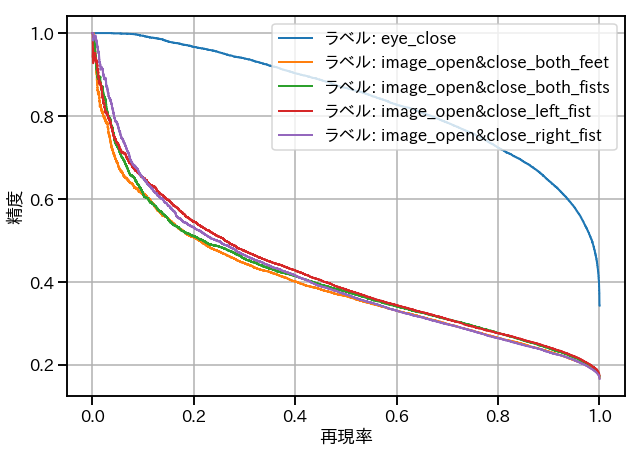

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
from scipy import interp
from itertools import cycle
lw = 2
precision = dict()
recall = dict()
plt.figure(figsize=(10, 7))
for i in range(n_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_valid[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=lw, label="ラベル: {}".format(ohe.categories_[0][i]))
plt.xlabel("再現率")
plt.ylabel("精度")
plt.grid()
plt.legend(loc="best")
# plt.title("精度再現率曲線")
# plt.savefig(results_path + "/precision_recall_curve", bbox_inches="tight")
#     plt.clf()
plt.show()

# 混同行列

In [21]:
from sklearn.metrics import classification_report

y_valid_inv = ohe.inverse_transform(y_valid)
y_pred_inv = ohe.inverse_transform(y_pred)
print(classification_report(y_valid_inv, y_pred_inv, target_names=ohe.categories_[0]))
# with open(results_path + "/classification_report.txt", "w") as file:
#     file.write(classification_report(y_valid_inv, y_pred_inv, target_names=ohe.categories_[0]))

                             precision    recall  f1-score   support

                  eye_close       0.69      0.84      0.76     52342
 image_open&close_both_feet       0.40      0.37      0.38     25315
image_open&close_both_fists       0.41      0.37      0.39     25676
 image_open&close_left_fist       0.43      0.36      0.39     26104
image_open&close_right_fist       0.41      0.36      0.39     25167

                   accuracy                           0.53    154604
                  macro avg       0.47      0.46      0.46    154604
               weighted avg       0.51      0.53      0.51    154604



# ROC曲線

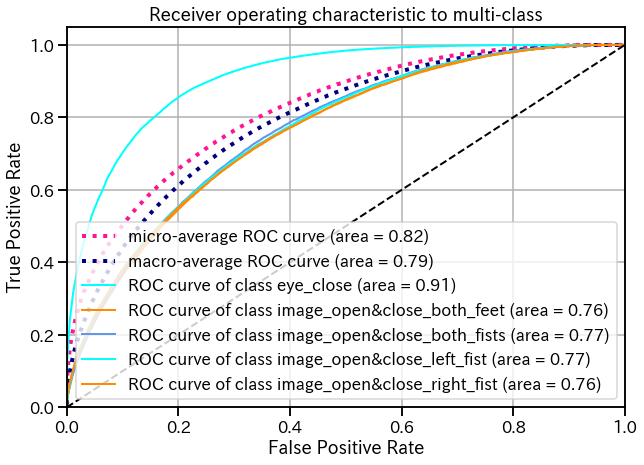

In [19]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_labels):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_labels)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
        label='micro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["micro"]),
        color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
        label='macro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["macro"]),
        color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(ohe.categories_[0][i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.grid()
# plt.savefig(results_path + "/roc_curve", bbox_inches="tight")
# plt.clf()
plt.show()

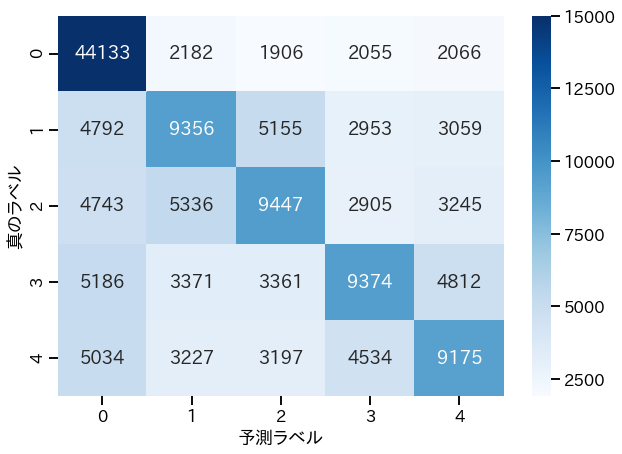

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_valid_inv, y_pred_inv)
cm_normalized = confusion_matrix(y_valid_inv, y_pred_inv, normalize="true")
with open(results_path + "/confusion_matrix.txt", "w") as file:
    file.write(np.array_str(cm))
with open(results_path + "/confusion_matrix_normalized.txt", "w") as file:
    file.write(np.array_str(cm_normalized))

import seaborn as sns
sns.set_context("talk")
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax, vmax=15000, cmap="Blues")
ax.set_xlabel('予測ラベル')
ax.set_ylabel('真のラベル')  
# ax.xaxis.set_ticklabels(ohe.categories_[0])
# ax.yaxis.set_ticklabels(ohe.categories_[0])
# plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.savefig(results_path + "/confusion_matrix", bbox_inches="tight")
# plt.clf()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
ax = plt.subplot()

import seaborn as sns
sns.set_context("talk")

sns.heatmap(cm_normalized, annot=True, fmt="g", ax=ax, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(ohe.categories_[0])
ax.yaxis.set_ticklabels(ohe.categories_[0])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
# plt.savefig(results_path + "/confusion_matrix_normalized", bbox_inches="tight")
plt.show()